# <center>Google Earth Engine API for MethaneSAT/AIR L3</center>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # full width notebook

## 1- Setup a Google Cloud Project

The [MethaneAIR L3 data](https://developers.google.com/earth-engine/datasets/catalog/EDF_MethaneSAT_MethaneAIR_L3concentration) can be fetched from the Google Earth Engine API<br>
You will need to setup a [Google Cloud Project](https://developers.google.com/earth-engine/cloud/earthengine_cloud_project_setup#get-access-to-earth-engine) in order to submit requests to Earth Engine

## 2- Download the data using Earth Engine python API

In [ ]:
import ee # EarthEngine
import time
import sys
import os
from typing import Optional
import warnings
warnings.simplefilter("ignore")

In [ ]:
def fetch_methaneair(
    projet: str,
    output_bucket: str,
    output_path: str = "tmp/sroche/MethaneAIR_EarthEngine", 
    collection: str = "EDF/MethaneSAT/MethaneAIR/L3concentration",
    field: Optional[str] = None,
    flight_id: Optional[str] = None,
    start_date: Optional[str] = None, 
    end_date: Optional[str] = None,
    scale: Optional[float] = None, # resolution in meters
):
    """
    Inputs:
        project (str): your EarthEngine project name, you will need your own cloud project here
        output_bucket (str): the tiff files will be downloaded to that bucket (don't include gs://), this is only the bucket name
        output_path (str): the tiff files will be downloaded to that path under the bucket
        collection (str): the EarthEngine collection name
        field (Optional[str]): band name (https://developers.google.com/earth-engine/datasets/catalog/EDF_MethaneSAT_MethaneAIR_L3concentration#bands)
                                if not given, the tiff will have all bands (300 MB per band)
        flight_id (Optional[str]): e.g. "RF08", if not given, all flights will be downloaded
        start_date (Optional[str]): YYYY-MM-DD; can be used with end_date to select a subset of flights
        end_date (Optional[str]): YYYY-MM-DD; can be used with start_date to select a subset of flights
        scale (Optional[float]): if given, tiff resolution in meters, get native resolution otherwise
    
    Ouputs:
        output_gs_paths (list[str]): list of the downloaded file paths on the output bucket
    """
    # Connect to Google Earth Engine API
    ee.Authenticate()

    ee.Initialize(project=project) # you will need your own cloud project here
    
    image_collection = ee.ImageCollection("EDF/MethaneSAT/MethaneAIR/L3concentration")
    
    if start_date is not None and end_date is not None:
        image_collection = image_collection.filterDate(start_date,end_date)
        
    if flight_id is not None:
        image_collection = image_collection.filter(ee.Filter.eq("flight_id",flight_id))
         
    # Export the images to a Google Cloud Storage bucket
    export_params = {
        'fileFormat': 'GeoTIFF',
        'bucket': output_bucket,
        'maxPixels':1e9,
    }
    if scale is not None:
        export_params["scale"] = scale

    output_gs_paths = []
    for image in image_collection.toList(image_collection.size()).getInfo():
        image_id = image['id']  # Get unique ID of the image
        image_object = ee.Image(image_id)  # Create the image object from the ID
        if field is not None:
            image_object = image_object.select(field)
        else:
            field = "AllBands"
        
        flight_id = image_object.get("flight_id").getInfo()

        # Customize the file name
        export_params['fileNamePrefix'] = f"{output_path}/{flight_id}_{field}"

        # Create export task
        task = ee.batch.Export.image.toCloudStorage(
            image=image_object,
            description=f'Export_MethaneAIR_{flight_id}_{field}',
            region=image_object.geometry().bounds(),  # Adjust the region as needed
            **export_params
        )

        task.start()

        while True:
            status = ee.data.getTaskStatus(task.id)[0]["state"]
            sys.stdout.write(f"Status: {status}\r")
            sys.stdout.flush()
            if status in ["COMPLETED","FAILED"]:
                break
            time.sleep(10)
        print(ee.data.getTaskStatus(task.id))
    
        output_gs_paths.append(f'gs://{export_params["bucket"]}/{export_params["fileNamePrefix"]}.tif')
    
    return output_gs_paths

In [ ]:
gs_paths = fetch_methaneair(
    project=project, # put your Google Cloud Project name here
    output_bucket=output_bucket # put the name of the gs bucket where the data will be saved
    output_path = "tmp/sroche/MethaneAIR_EarthEngine", # path to the directory (under output_bucket) where files will be saved
    field="XCH4",
    flight_id="RF06",
    output_path="tmp/sroche/MethaneAIR_EarthEngine"
)

Download the file locally

In [ ]:
os.system(f"gsutil cp {gs_paths[0]} {os.getcwd()}/)

## Plot the data

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
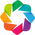

In [2]:
from msatutil.mair_geoviews import show_map, save_static_plot_with_widgets #https://github.com/rocheseb/msatutil
import rioxarray

In [3]:
def read_tif(path: str,field: str):
    """
    Read a geotif file
    
    Inputs:
        path (str): full path to the .tif file
        field (str): name of the band to read
    
    Outputs:
        lon: Longitudes
        lat: latitudes
        band_raster: the field data
    """
    # Open the GeoTIFF file using rioxarray
    raster = rioxarray.open_rasterio(path)
    
    band = raster.attrs["long_name"].index(field)+1

    band_raster = raster.sel(band=band)
    
    bounds = band_raster.rio.bounds()

    crs = band_raster.rio.crs

    lat = band_raster.coords['y']
    lon = band_raster.coords['x']
    
    return lon,lat,band_raster

In [4]:
lon,lat,xch4 = read_tif("RF06_XCH4.tif","XCH4")

In [ ]:
plot = show_map(lon,lat,xch4,clim=(1750,2050),width=650,height=550)

In [ ]:
save_static_plot_with_widgets(
    "RF06_L3_map.html",
    plot,
    layout_title = "MethaneAIR RF06",
    layout_details = "Mapping area of MethaneAIR RF06 on 2021/08/06"
)

In [ ]:
HTML("RF06_L3_map.html")

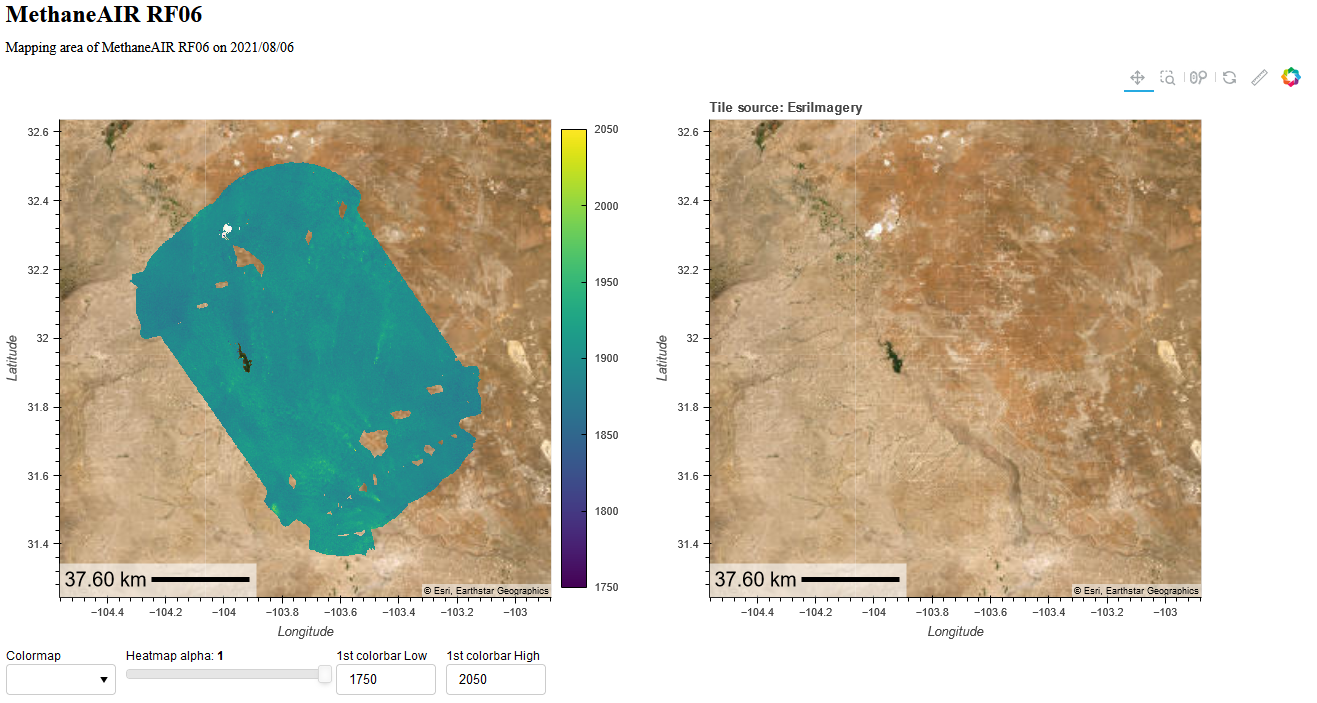